# Hubbard Hamiltonian

In [2]:
import sys
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numba import njit
from numba.typed import List, Dict
import scipy as sc
import seaborn as sns
import concurrent.futures
import pickle
import multiprocessing as mp
import pathlib
import os, sys
import re
import sympy as sym
from tqdm import tqdm, notebook
from matplotlib import ticker
import math
from itertools import combinations_with_replacement, permutations, combinations
from bisect import bisect_left

## Defining all the calculation functions for further use
They will also be exported to a file for later use in other projects

In [3]:
@njit
def calc_Dim(M, N, statistic='b'):
    if statistic == 'b':
        return int(np.math.gamma(N+M)/(np.math.gamma(N+1)*np.math.gamma(M)))
    elif statistic == 'f':
        return int((np.math.gamma(M+1))/(np.math.gamma(N+1)*np.math.gamma(M-N+1)))
    else:
        raise ValueError("Incorrect statistic")

In [4]:
@njit(parallel=True)
def get_basis(M,N, statistic='b', verb=0):
    """
    A function generating a Fock Basis for many-body calculations. Default is for Bosons, optional for Fermions

    :param M:
    :param N:
    :param verb:
    :param statistic:
    :return:
    """
    # Defining empty array for the basis vectors
    if statistic == 'b':
        D = calc_Dim(M, N, 'b')
        A = np.zeros(shape=(D,M), dtype=np.int64)
    elif statistic == 'f':
        if N > M:
            raise ValueError("Non-physical fermion number")
        D = calc_Dim(M, N, 'b')
        A = np.zeros(shape=(D,M), dtype=np.int64)
        # dim_F = math.comb(M, N)
        dim_F = calc_Dim(M, N, statistic)
        A_F = np.zeros(shape=(dim_F, M), dtype=np.int64)
        a_f_ind = 0
    elif statistic == 'f_2':
        if N > M:
            raise ValueError("Non-physical fermion number")
        dim_F = calc_Dim(M, N, statistic)
        A = np.zeros(shape=(dim_F, M), dtype=np.int64)
    else:
        raise ValueError("Incorrect statistic")

    # Setting up the basis vectors
    if statistic != 'f_2':
        for num, row in enumerate(A):
            if num != 0:
                row_old = A[num-1].copy()
                row_new = row.copy()
                k_ind = np.max(np.nonzero(row_old[:M-1])[0])
                if row_old[k_ind+1] != 0:
                    k_ind = np.max(np.nonzero(A[num-2][:M-1])[0])
                # Setting the new row
                for i in range(0, k_ind):
                    row_new[i] = row_old[i]
                row_new[k_ind] = row_old[k_ind] - 1
                existing_sum = 0
                for pos in range(len(row_new)):
                    if pos >= k_ind+3:
                        continue
                    else:
                        existing_sum += row_new[pos]
                row_new[k_ind+1] = N - existing_sum

                # Copying back the new row
                A[num] = row_new
                if statistic == 'f':
                    if np.max(row_new) < 2:
                        A_F[a_f_ind] = row_new
                        a_f_ind += 1
            else:
                row[0] = N
                if statistic == 'f':
                    if np.max(row) < 2:
                        A_F[a_f_ind] = row
                        a_f_ind += 1

    # Develoment in progress, not fully functional as of now!!!!
    else:
        # Setting up the basis vectors
        for num, row in enumerate(A):
            if num != 0:
                row_old = A[num-1].copy()
                row_new = row.copy()
                k_ind = np.max(np.nonzero(row_old[:M-1])[0])
                if row_old[k_ind+1] != 0:
                    k_ind = np.max(np.nonzero(A[num-2][:M-1])[0])
                # if row_old[k_ind] == 0:
                #     k_ind -= 1
                # Setting the new row
                for i in range(0, k_ind):
                    row_new[i] = row_old[i]
                row_new[k_ind] = row_old[k_ind] - 1
                existing_sum = 0
                for pos in range(len(row_new)):
                    if pos >= k_ind+3:
                        continue
                    else:
                        existing_sum += row_new[pos]
                num_left = N - existing_sum
                if num_left > 1:
                    for i in range(0, num_left):
                        row_new[k_ind+1] = 1
                        k_ind += 1
                else:
                    row_new[k_ind+1] = 1

                # Copying back the new row
                A[num] = row_new

            else:
                for i in range(0, N):
                    row[i] = 1

    if verb > 0:
        if statistic == 'b' or statistic == 'f_2':
            print(A)
        elif statistic == 'f':
            print(A_F)
        else:
            raise ValueError("Incorrect statistic")
    if statistic == 'b' or statistic == 'f_2':
        return A
    elif statistic == 'f':
        return A_F
    else:
        raise ValueError("Incorrect statistic")

In [5]:
@njit
def get_tensor_basis(M,N, statistic='b', n_components=1, verb=0):
    vec_num = 0
    if statistic == 'b':
        D = calc_Dim(M, N, 'b')
        A = np.zeros(shape=(D**2,M*n_components), dtype=np.int64)
    elif statistic == 'f':
        if N > M:
            raise ValueError("Non-physical fermion number")
        dim_F = calc_Dim(M, N, statistic)
        A = np.zeros(shape=(dim_F**2, M*n_components), dtype=np.int64)
    else:
        raise ValueError("Incorrect statistic")
    if n_components == 1:
        return get_basis(M,N, statistic=statistic, verb=verb)
    else:
        bases = {}
        for comp_num in range(0, n_components):
            if verb > 0:
                print("Generating basis for component no.", comp_num)
            bases[comp_num] = get_basis(M, N, statistic=statistic, verb=verb)

        for ket_1 in bases[0]:
            for ket_2 in bases[1]:
                A[vec_num] = np.concatenate((ket_1, ket_2))
                vec_num+=1
    return A


In [6]:
@njit
def a_operator(i_ind, ket, kind='c', component_number=None, ket_size=None, statistic="b", pbc=0):
    """
    A joint function for anihillation and creation operators for bosons (b_i, b_i^\dagger) and fermions (c_i, c_i^\dagger) which acts on input ket from multi-particle Fock basis.

    :param i_ind: Index of interest (as in a_i)
    :param ket: The basis vector the operator acts on
    :param kind: Operator kind, either 'c' for creation' or 'a' for anihillation is permitted
    :param component_number: Number of component in a tensor-multiplied basis. If none, then singular basis is assumed. Numbering from 0
    :param ket_size: Size of single component of tensor-multiplied basis
    :param statistic: Particle statistic, 'b' for Boson, or 'f' for Fermion
    :param pbc: Periodic Boundary Conditions. 0 - off, 1 - on
    :return: Returns multiplying factor, and new ket
    """
    # Setting which site should be modified based on boundary conditions.
    if pbc == 0:
        i_mod = i_ind
    else:
        i_mod = np.mod(i_ind, ket.shape[0])
    # Creation operator
    if kind == "c":
        if statistic == "b":
            if component_number is None:
                factor = np.sqrt(ket[i_mod]+1)
                ket_new = ket.copy()
                ket_new[i_mod] += 1
            else:
                ket_to_mod = ket[component_number*ket_size:(component_number+1)*ket_size]
                factor = np.sqrt(ket_to_mod[i_mod]+1)
                ket_new = ket_to_mod.copy()
                ket_new[i_mod] += 1
                before = ket[0:(component_number)*ket_size]
                after = ket[(component_number+1)*ket_size:(component_number+2)*ket_size]
                ket_out = np.concatenate((before, ket_new, after))
                return factor, ket_out
        if statistic == "f":
            if component_number is None:
                if ket[i_mod] == 1:
                    return 0, ket
                factor = np.sqrt(ket[i_mod]+1)
                ket_new = ket.copy()
                ket_new[i_mod] += 1
            else:
                ket_to_mod = ket[component_number*ket_size:(component_number+1)*ket_size]
                if ket_to_mod[i_mod] == 1:
                    return 0, ket
                minus_factor = np.count_nonzero(ket[component_number*ket_size:component_number*ket_size+i_mod])
                factor = np.sqrt(ket_to_mod[i_mod]+1)*np.power(-1, minus_factor)
                ket_new = ket_to_mod.copy()
                ket_new[i_mod] += 1
                # print(ket_new)
                before = ket[0:(component_number)*ket_size]
                after = ket[(component_number+1)*ket_size:(component_number+2)*ket_size]
                ket_out = np.concatenate((before, ket_new, after))
                # print(ket_out)
                return factor, ket_out
    # Anihillation operator
    if kind == "a":
        if statistic == "b":
            if component_number is None:
                if ket[i_mod] == 0:
                    return 0, ket
                factor = np.sqrt(ket[i_mod])
                ket_new = ket.copy()
                ket_new[i_mod] -= 1
            else:
                ket_to_mod = ket[component_number*ket_size:(component_number+1)*ket_size]
                if ket_to_mod[i_mod] == 0:
                    return 0, ket
                factor = np.sqrt(ket_to_mod[i_mod])
                ket_new = ket_to_mod.copy()
                ket_new[i_mod] -= 1
                before = ket[0:(component_number)*ket_size]
                after = ket[(component_number+1)*ket_size:(component_number+2)*ket_size]
                ket_out = np.concatenate((before, ket_new, after))
                return factor, ket_out
        if statistic == "f":
            if component_number is None:
                if ket[i_mod] == 0:
                    return 0, ket
                factor = np.sqrt(ket[i_mod])
                ket_new = ket.copy()
                ket_new[i_mod] -= 1
            else:
                ket_to_mod = ket[component_number*ket_size:(component_number+1)*ket_size]
                if ket_to_mod[i_mod] == 0:
                    return 0, ket
                minus_factor = np.count_nonzero(ket[component_number*ket_size:component_number*ket_size+i_mod])
                factor = np.sqrt(ket_to_mod[i_mod])*np.power(-1, minus_factor)
                ket_new = ket_to_mod.copy()
                ket_new[i_mod] -= 1
                # print(ket_new)
                before = ket[0:(component_number)*ket_size]
                after = ket[(component_number+1)*ket_size:(component_number+2)*ket_size]
                ket_out = np.concatenate((before, ket_new, after))
                # print(ket_out)
                return factor, ket_out
    return factor, ket_new

In [7]:
def calc_IPR(ket):
    return 1/np.sum([(lambda i: ket[i]**4)(i) for i in range(0, ket.shape[0])])

In [8]:
@njit
def tag_func(v):
    """
    The tagging function, which hashes all the basis vectors with unique values, according to equation:
    T(v) = \sum_i \sqrt{p_i} v_i where i is the index of element in the vector

    :param v: A vector to hash
    :return: Hash of the vector
    """
    res_tab = np.zeros(len(v))
    for i in range(0,len(v)):
        res_tab[i] = np.sqrt(100*(i+1)+3)*v[i]
    return np.sum(res_tab)

In [9]:
@njit
def find_orig_idx(ket, t_dict):
    """
    Function for finding which basis vector is the input ket

    :param ket: Hashed ket to be searched in the original Hilbert space basis
    :param t_dict: dictionary of hashed basis vectors
    :return: Index of input vector in the original ordered basis of the Hilbert space
    """
    ket_hash = tag_func(ket)
    try:
        a = t_dict[ket_hash]
        return int(a)
    except Exception:
        return -1
    # sorted_idx = np.searchsorted(t_sorted, ket_hash)
    # if ket_hash != t_sorted[sorted_idx]:
    #     # Here taking care of vectors that are not in the basis
    #     return -1
    # else:
    #     return ind[sorted_idx]

In [10]:
@njit
def get_kinetic_H(A, M, J, t_dict, pbc=0, statistic='b', component_no=1):
    values = List()

    ket_idx_list = List()

    ket_tilde_tilde_idx_list = List()

    ket_len = M

    if pbc == 0:
        range_end = M-1
    else:
        range_end = M

    # for component_no in range(0, n_components):
    for ket in A:
        for i in range(0, range_end):

            if pbc == 0:
                i_next = i+1
            else:
                i_next = np.mod(i+1, ket_len)

            for (anihillated, created) in [(i, i_next), (i_next, i)]:
                if ket[component_no*ket_len+anihillated] > 0:

                    factor_1, ket_tilde = a_operator(anihillated, ket, 'a', pbc=pbc, statistic=statistic, component_number=component_no, ket_size=ket_len)
                    factor_2, ket_tilde_tilde = a_operator(created, ket_tilde, 'c', pbc=pbc, statistic=statistic, component_number=component_no, ket_size=ket_len)

                    ket_idx = find_orig_idx(ket, t_dict)
                    ket_tilde_tilde_idx = find_orig_idx(ket_tilde_tilde, t_dict)

                    val = J*factor_1*factor_2

                    if ket_tilde_tilde_idx == -1 or np.abs(val) == 0:
                        continue
                    else:

                        values.append(val)

                        ket_idx_list.append(ket_idx)

                        ket_tilde_tilde_idx_list.append(ket_tilde_tilde_idx)

    return values, ket_idx_list, ket_tilde_tilde_idx_list

In [11]:
@njit
def get_interactions_H(A, M, U, t_dict, statistic='b'):
    values = List()

    ket_idx_list = List()

    ket_tilde_tilde_idx_list = List()
    for ket in A:
        for i in range(0, M):
            if ket[i] == 0:
                continue
            else:
                factor_1, ket_t1 = a_operator(i, ket, 'a', statistic=statistic)
                factor_2, ket_t2 = a_operator(i, ket_t1, 'c', statistic=statistic)
                factor_3, ket_t3 = a_operator(i, ket_t2, 'a', statistic=statistic)
                factor_4, ket_t4 = a_operator(i, ket_t3, 'c', statistic=statistic)

                ket_idx = find_orig_idx(ket, t_dict)
                ket_tilde_tilde_idx = find_orig_idx(ket_t4, t_dict)

                val = (U/2.0)*factor_1*factor_2*factor_3*factor_4

                values.append(val)

                ket_idx_list.append(ket_idx)

                ket_tilde_tilde_idx_list.append(ket_tilde_tilde_idx)

                # Second part of the equation

                factor_1_bis, ket_t1_bis = a_operator(i, ket, 'a', statistic=statistic)
                factor_2_bis, ket_t2_bis = a_operator(i, ket_t1_bis, 'c', statistic=statistic)

                ket_idx = find_orig_idx(ket, t_dict)
                ket_tilde_tilde_idx_bis = find_orig_idx(ket_t2_bis, t_dict)

                val_bis = (-1)*(U/2.0)*factor_1_bis*factor_2_bis

                values.append(val_bis)

                ket_idx_list.append(ket_idx)

                ket_tilde_tilde_idx_list.append(ket_tilde_tilde_idx_bis)

    return values, ket_idx_list, ket_tilde_tilde_idx_list

In [12]:
def plot_coo_matrix(m, title=None):
    """
    A function for plotting sparse matrix sparcity pattern

    :param m: Matrix to be plotted
    :param title: Optional variable for labeling the plot
    :return: Matplotlib axis object
    """
    if not isinstance(m, sc.sparse.coo_matrix):
        m = sc.sparse.coo_matrix(m)
    fig = plt.figure(figsize=(8,8), facecolor="silver")
    ax = fig.add_subplot(111)
    ax.plot(m.col, m.row, 's', color='k', ms=2)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    if title:
        ax.set_title(title, fontsize=20, color='firebrick')
    for spine in ax.spines.values():
        spine.set_visible(True)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    # ax.set_xticks([])
    # ax.set_yticks([])
    return ax

In [13]:
def save_sparse_coo(filename, array):
    # note that .npz extension is added automatically
    sc.sparse.save_npz(filename, array)

def load_sparse_coo(filename):
    # here we need to add .npz extension manually
    loader = sc.sparse.load_npz(filename + '.npz')
    return loader

In [14]:
def get_Hamiltonian(N, M, J, U, pbc=0, statistic='b', n_components=1, basis_apriori=None, save_sparse=False, plot_accurate=False, annot_accurate=False, plot_sparsity_pattern=False, save_plot=False, return_basis=False, plot_show=False):
    """
    A function for generating a 1-D Bose-Hubbard model Hamiltonian. The system is defined by parameters N - total number of particles in the system, M - total number of sites in the chain, J - Hopping parameter, U - On-site potential parameter.

    :param N: Total number of paricles in the system
    :param M: Total number of sites in the chain
    :param J: Hoppin parameter
    :param U: On-site potential parameter
    :param pbc: Periodic Boundary Conditions. 0 - off, 1 - on
    :param save_sparse: Save resulting Hamitonian in sparse format in the working directory
    :param plot_accurate: Plot accurately all the fields of the resulting Hamiltonian. If 'annot_accurate' kwarg is set to True, then actual values are also annotated
    :param annot_accurate: Only takes effect if `plot_accurate` is set to True, annotates plotted Hamiltonian with exact values
    :param plot_sparsity_pattern: Plots general shape of non-zero element in Hamiltonian. Useful with large matrices, which are not suitable for exact plotting
    :param save_plot: Saves plotted precise plot/sparcity pattern
    :param return_basis: If set to True, then the generated Fock basis is also returned
    :param plot_show: Should drawn plot be shown, flag added for just saving generated plots
    :return: Hamiltonian in COO sparse matrix format, or a tuple containing spare Hamiltonian, and a dense matrix with Fock basis states
    """
    if statistic == 'b':
        D = calc_Dim(M, N, statistic)
    elif statistic == 'f':
        if N > M:
            raise ValueError("Non-physical fermion number")
        D = calc_Dim(M, N, statistic)
    else:
        raise ValueError("Incorrect statistic")
    if basis_apriori is None:
        # Setting the occupational basis:
        A = get_tensor_basis(M, N, statistic=statistic, n_components=n_components)
    else:
        A = basis_apriori

    # # Getting the basis vectors hashed
    # tab_T = np.array([tag_func(v) for v in A])
    # # Preserving the original order of basis vectors
    # ind = np.argsort(tab_T)
    # # Sorting the new array for more efficient searching (by bisection)
    # t_sorted = tab_T.copy()
    # t_sorted.sort()
    t_dict = Dict()
    for key, val in zip(tab_T, np.arange(0, A.shape[0])):
        t_dict[key] = val

    # First tab - values, last two tabs - coordinates
    H_kin_prep = [List(), List(), List()]
    H_int_prep = [List(), List(), List()]

    H_kin_prep = get_kinetic_H(A, M, J, t_dict, pbc=pbc, statistic=statistic)
    H_int_prep = get_interactions_H(A, M, U, t_dict, statistic=statistic)

    mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D, D))
    mat_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))

    Total_H = mat + mat_int

    if save_sparse:
        p = pathlib.Path.cwd().joinpath("{}_component".format(n_components)).joinpath("Hamiltonians").joinpath("N={}_L={}".format(N, M))
        if not p.exists():
            p.mkdir(parents=True, exist_ok=True)
        sc.sparse.save_npz("{}_component/Hamiltonians/N={}_L={}/{}_Hamiltonian_N={}_L={}_U_J=".format(n_components, N, M, 'BH' if stat == 'b' else 'FH', N, M)+re.sub("\\.", "_", "{:.2f}".format(U/J))+"", Total_H)

    if plot_sparsity_pattern:
        ax = plot_coo_matrix(Total_H, title="N = {}, L = {}, U/J = {}, dim = {}".format(N, M, U/J, D))
        if save_plot:
            p_sparse = pathlib.Path.cwd().joinpath("{}_component".format(n_components)).joinpath("Plots").joinpath("Hamiltonians").joinpath("N={}_L={}".format(N, M))
            if not p_sparse.exists():
                p_sparse.mkdir(parents=True, exist_ok=True)
            if pbc == 1:
                ax.figure.savefig("{}_component/Plots/Hamiltonians/N={}_L={}/{}_Hamiltonian_sparse_N={}_L={}_U_J=".format(n_components, N, M, 'BH' if stat == 'b' else 'FH', N, M)+re.sub("\\.", "_", "{:.2f}".format(U/J))+"_PBC.pdf")
            else:
                ax.figure.savefig("{}_component/Plots/Hamiltonians/N={}_L={}/{}_Hamiltonian_sparse_N={}_L={}_U_J=".format(n_components, N, M, 'BH' if stat == 'b' else 'FH', N, M)+re.sub("\\.", "_", "{:.2f}".format(U/J))+".pdf")
        if plot_show:
            ax.figure.show()
        plt.close()

    if plot_accurate:
        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(111)
        ax.set_title("N = {}, L = {}, U/J = {}, dim = {}".format(N, M, U/J, D))
        sns.heatmap(Total_H.toarray(), square=True, cmap='coolwarm', annot=annot_accurate, ax=ax)
        if save_plot:
            p_plot = pathlib.Path.cwd().joinpath("{}_component".format(n_components)).joinpath("Plots").joinpath("Hamiltonians").joinpath("N={}_L={}".format(N, M))
            if not p_plot.exists():
                p_plot.mkdir(parents=True, exist_ok=True)
            if pbc == 1:
                fig.savefig("{}_component/Plots/Hamiltonians/N={}_L={}/{}_Hamiltonian_N={}_L={}_U_J=".format(n_components, N, M, 'BH' if stat == 'b' else 'FH', N, M)+re.sub("\\.", "_", "{:.2f}".format(U/J))+"_PBC.pdf")
            else:
                fig.savefig("{}_component/Plots/Hamiltonians/N={}_L={}/{}_Hamiltonian_N={}_L={}_U_J=".format(n_components, N, M, 'BH' if stat == 'b' else 'FH', N, M)+re.sub("\\.", "_", "{:.2f}".format(U/J))+".pdf")
        if plot_show:
            plt.show(fig)
        plt.close()

    if return_basis:
        return Total_H, A
    else:
        return Total_H

In [15]:
@njit
def fock_dot(ket_w, ket_v):
    if np.array_equal(ket_w, ket_v):
        return 1
    else:
        return 0

In [16]:
@njit
def get_density_matrix_comp(M, Fock_Basis, evecs, pbc, k=0, statistic='b'):
    values = List()

    pos_i_list = List()

    pos_j_list = List()

    range_end = M

    ket_psi = evecs[:, k]

    for i in range(0, range_end):
        for j in range(0, range_end):
            for num_w, ket_w in enumerate(Fock_Basis):
                for num_v, ket_v in enumerate(Fock_Basis):
                    c_ij = 0
                    for (anihillated, created) in [(j, i)]:
                        hash_val = 0
                        factor_1, ket_v_tilde = a_operator(anihillated, ket_v, 'a', pbc=pbc, statistic=statistic)
                        factor_2, ket_v_tilde_tilde = a_operator(created, ket_v_tilde, 'c', pbc=pbc, statistic=statistic)

                        hash_val = factor_1*factor_2*fock_dot(ket_w, ket_v_tilde_tilde)*np.conj(ket_psi[num_w])*ket_psi[num_v]
                        c_ij += hash_val

                    if c_ij == 0:
                        pass
                    else:
                        values.append(float(c_ij))

                        pos_i_list.append(i)

                        pos_j_list.append(j)

    return values, pos_i_list, pos_j_list

In [17]:
def get_density_matrix(N, M, Fock_Basis, evecs, pbc, U, J, k=0, statistic='b', save_sparse=False, save_plot=False, plot_show=False, annot_plot=False, n_components=1):
    # first for the ground state, k = 0
    # First tab - values, second and third - coordinates
    rho_k = [List(), List(), List()]
    rho_k = get_density_matrix_comp(M, Fock_Basis, evecs, pbc, statistic=statistic)
    rho_k = sc.sparse.coo_matrix((rho_k[0], (rho_k[1], rho_k[2])), shape=(M, M))
    if save_sparse:
        p = pathlib.Path.cwd().joinpath("{}_component".format(n_components)).joinpath("Density_Matrices").joinpath("N={}_L={}".format(N, M))
        if not p.exists():
            p.mkdir(parents=True, exist_ok=True)
        sc.sparse.save_npz("{}_component/Density_Matrices/N={}_L={}/{}_DM_N={}_L={}_U_J=".format(n_components,N , M, 'BH' if stat == 'b' else 'FH', N, M)+re.sub("\\.", "_", "{:.2f}".format(U/J))+"_k={}".format(k), rho_k)
    if save_plot:
        p_plot = pathlib.Path.cwd().joinpath("{}_component".format(n_components)).joinpath("Plots").joinpath("Density_Matrices").joinpath("N={}_L={}".format(N, M))
        if not p_plot.exists():
            p_plot.mkdir(parents=True, exist_ok=True)
        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(111)
        ax.set_title("N = {}, L = {}, U/J={}".format(N, M, U/J))
        sns.heatmap(np.matrix(rho_k.toarray()), square=True, cmap='coolwarm', annot=annot_plot, ax=ax)
        fig.savefig("{}_component/Plots/Density_Matrices/N={}_L={}/{}_Hamiltonian_N={}_L={}_U_J=".format(n_components, N, M, 'BH' if stat == 'b' else 'FH', N, M)+re.sub("\\.", "_", "{:.2f}".format(U/J))+".pdf")
        if plot_show:
            plt.show(fig)
        plt.close()
    return rho_k

In [18]:
@njit
def get_n_i_squared(i, Fock_Basis, evecs, pbc=0, k=0):
    values = List()

    pos_i_list = List()

    pos_j_list = List()

    ket_psi = evecs[:, k]

    for num_w, ket_w in enumerate(Fock_Basis):
        for num_v, ket_v in enumerate(Fock_Basis):
            # if pbc == 0:
            #     i_next = i+1
            # else:
            #     i_next = np.mod(i+1, ket.shape[0])
            c_ii = 0
            for (anihillated, created) in [(i, i)]:
                hash_val = 0
                factor_1, ket_v_tilde = a_operator(anihillated, ket_v, 'a', pbc=pbc)
                factor_2, ket_v_2_tilde = a_operator(created, ket_v_tilde, 'c', pbc=pbc)
                factor_3, ket_v_3_tilde = a_operator(anihillated, ket_v_2_tilde, 'a', pbc=pbc)
                factor_4, ket_v_4_tilde = a_operator(created, ket_v_3_tilde, 'c', pbc=pbc)

                hash_val = factor_1*factor_2*factor_3*factor_4*fock_dot(ket_w, ket_v_4_tilde)*np.conj(ket_psi[num_w])*ket_psi[num_v]
                c_ii += hash_val

            if c_ii == 0:
                pass
            else:
                values.append(float(c_ii))

                pos_i_list.append(i)

                pos_j_list.append(i)

    return sum(values)

In [19]:
@njit
def get_n_i_variance(i, ni_in, Fock_Basis, evecs, pbc=0, k=0):
    ni_sq = get_n_i_squared(i, Fock_Basis, evecs, pbc, k)
    sq_ni = np.power(ni_in, 2)
    return np.sqrt(ni_sq - sq_ni)

In [20]:
def get_total_variance(N, rho_k, Fock_Basis, evecs, pbc=0, k=0):
    i_tab = np.arange(0,N)
    var_tot = 0
    with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
        future_to_n_i_variations = {executor.submit(get_n_i_variance, i, rho_k.diagonal()[i], Fock_Basis, evecs, pbc, k): i for i in i_tab}
        for future in concurrent.futures.as_completed(future_to_n_i_variations):
            # print("Completed i = {}, result = {:.5f}".format(future_to_n_i_variations[future], future.result()))
            var_tot += future.result()
        var_tot /= N
    return var_tot

In [21]:
def get_data_for_plots(M,N,J,U,pbc=0,k=0,basis_apriori=None, plot_type='sparse'):
    if basis_apriori is None:
        Fock_Basis = get_basis(M, N)
    else:
        Fock_Basis = basis_apriori
    if plot_type == 'sparse':
        sparse_type = True
        accurate_type = False
        save_parameter = True
    elif plot_type == 'off':
        sparse_type = False
        accurate_type = False
        save_parameter = False
    else:
        sparse_type = False
        accurate_type = True
        save_parameter = True
    H = get_Hamiltonian(N=N, M=M, J=J, U=U, basis_apriori=Fock_Basis, pbc=1, plot_accurate=accurate_type, annot_accurate=False, plot_sparsity_pattern=sparse_type, save_plot=save_parameter, return_basis=False, save_sparse=True, plot_show=False)
    evals, evecs = sc.sparse.linalg.eigsh(H, 2, which='SA', return_eigenvectors=True)
    delta_E = evals[1] - evals[0]
    rho_k = get_density_matrix(N, M, Fock_Basis, evecs, pbc, U, J, save_sparse=True, save_plot=save_parameter)
    lambda_1 = sc.sparse.linalg.eigsh(rho_k, 1, which='LA', return_eigenvectors=False)[0]
    f_c = lambda_1 / N
    rho_csr = sc.sparse.csr_matrix(rho_k)
    correltation = rho_csr[0, (M//2)-1]
    var_tot = get_total_variance(N, rho_k, Fock_Basis, evecs, pbc, k)
    return {"delta_E": delta_E, "f_c": f_c, "total_variance": var_tot, "correlation" : correltation}

In [22]:
def generate_data(N, M, J, U_range=None, pbc=1, plot_type='sparse'):
    if U_range is None:
        U_tab = np.arange(0, 20, 1)
    else:
        U_tab = U_range
    D = calc_Dim(M, N)
    Fock_Basis = get_basis(M, N)
    plot_data = {"U/J" : [], "Delta_E": [], "f_c": [], "total_variance": [], "correlation": []}
    with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
        future_to_plot_parameters = {executor.submit(get_data_for_plots, M, N, J, U, pbc, basis_apriori=Fock_Basis, plot_type=plot_type): U for U in U_tab}
        for future in concurrent.futures.as_completed(future_to_plot_parameters):
            # result[future_to_plot_parameters[future]] = future.result()
            plot_data["U/J"].append(future_to_plot_parameters[future])
            plot_data["Delta_E"].append(future.result()['delta_E'])
            plot_data["f_c"].append(future.result()['f_c'])
            plot_data["total_variance"].append(future.result()['total_variance'])
            plot_data["correlation"].append(future.result()['correlation'])
    return plot_data

## Demonstration of process

### Control constants

In [23]:
# N - Number of particles in a system
N = 2
# M - Number of sites to fill
M = 3
# J - Hopping scaling factor
J = -1
# U - On-site potential scaling factor
U = 1
# Statistic (bose/fermi)
stat = 'f'
# Comp no
comp_no = 2
# Periodic bounary conditions
pbc = 0

# D - Dimension of the final Hamiltonian matrix
D = calc_Dim(M, N, statistic=stat)

### Generating basis vectors

In [24]:
A = get_tensor_basis(M, N, statistic=stat, n_components=comp_no)
A.shape

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(9, 6)

### Hashing the basis for more efficient search

In [25]:
# Getting the basis vectors hashed
tab_T = np.array([tag_func(v) for v in A])

In [26]:
%%time
# Preserving the original order of basis vectors
ind = np.argsort(tab_T)
# Sorting the new array for more efficient searching (by bisection)
t_sorted = tab_T.copy()
t_sorted.sort()
t_dict = Dict()
for key, val in zip(tab_T, np.arange(0, A.shape[0])):
    t_dict[key] = val

CPU times: user 309 ms, sys: 3.24 ms, total: 312 ms
Wall time: 313 ms


### Getting the kinetic part of Hamiltonian

The Hamiltonian for the kinetic part is in our case:
$$ \hat{H}_{kin} = -J\sum_{i = 0}^{M-1} (a^\dagger_i a_{i+1} + a^\dagger_{i+1}a_i) $$

And the individual element in row $u$ and column $v$ is:
$$ \hat{H}_{u, v} = \langle u | \hat{H} | v \rangle = factor_1 \cdot factor_2 \cdot (-J)$$

In [27]:
# First tab - values, last two tabs - coordinates
H_kin_prep = [List(), List(), List()]

Here we have a PBC option enabled

In [28]:
H_kin_prep = get_kinetic_H(A, M, J, t_dict, pbc=pbc, statistic=stat, component_no=0)

Output data type is A list of typed lists from Numba, for the function to be JIT-compilable

In [29]:
H_kin_prep

(ListType[float64]([-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, ...]),
 ListType[int64]([0, 1, 2, 3, 3, 4, 4, 5, 5, 6, 7, 8, ...]),
 ListType[int64]([3, 4, 5, 6, 0, 7, 1, 8, 2, 3, 4, 5, ...]))

In [30]:
mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D**comp_no, D**comp_no))

In [31]:
mat_out = mat

In [32]:
H_kin_prep = get_kinetic_H(A, M, J, t_dict, pbc=pbc, statistic=stat, component_no=1)

In [33]:
mat = sc.sparse.coo_matrix((H_kin_prep[0], (H_kin_prep[1], H_kin_prep[2])), shape=(D**comp_no, D**comp_no))

In [34]:
mat_out += mat

In [35]:
mat_dense = mat_out.toarray()

<AxesSubplot:>

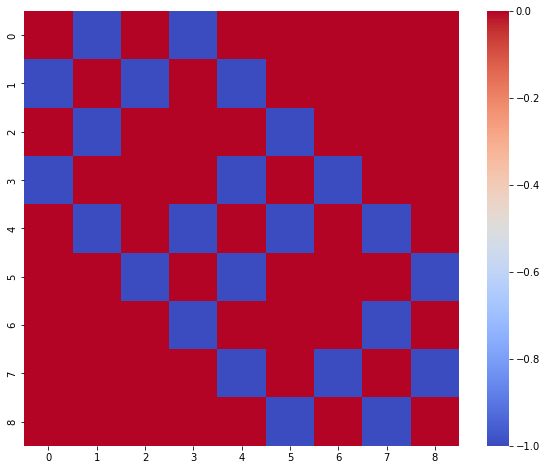

In [36]:
plt.figure(figsize=(10,8))
sns.heatmap(mat_dense, square=True, cmap='coolwarm')

In [ ]:
# b = sym.Matrix(mat_dense)

In [ ]:
# b

In [ ]:
# b.jordan_form(calc_transform=False)

In [316]:
# b.jordan_form(calc_transform=False)

### The diagonal part

The Hamiltonian for the interactions part is in our case:
$$ \hat{H}_{int} = \frac{U}{2}\sum_{i = 0}^{M} \hat{n}_i(\hat{n}_i - 1)= \frac{U}{2}\sum_{i = 0}^{M} a^\dagger_i a_{i}(a^\dagger_{i}a_i - 1) $$

And the individual diagonal element in row $v$ and column $v$ is:
$$ \hat{H}_{v, v} = \langle v | \hat{H}_{int} | v \rangle = \frac{U}{2} (factor_1^2 \cdot factor_2^2 - factor_1' \cdot factor_2')$$

In [32]:
# First tab - values, last two tabs - coordinates
H_int_prep = [List(), List(), List()]

In [33]:
H_int_prep = get_interactions_H(A, M, U, t_dict, statistic=stat)

Output data type is A list of typed lists from Numba, for the function to be JIT-compilable

In [62]:
H_int_prep

NameError: name 'H_int_prep' is not defined

In [35]:
mat_int = sc.sparse.coo_matrix((H_int_prep[0], (H_int_prep[1], H_int_prep[2])), shape=(D, D))

In [36]:
mat_int_dense = mat_int.toarray()

<AxesSubplot:>

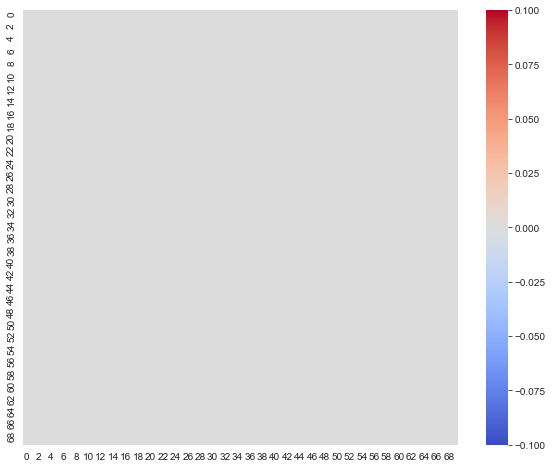

In [37]:
plt.figure(figsize=(10,8))
sns.heatmap(mat_int_dense, square=True, cmap='coolwarm')

### Both matrices joined together

<AxesSubplot:title={'center':'N = 4, L = 8, dim = 70'}>

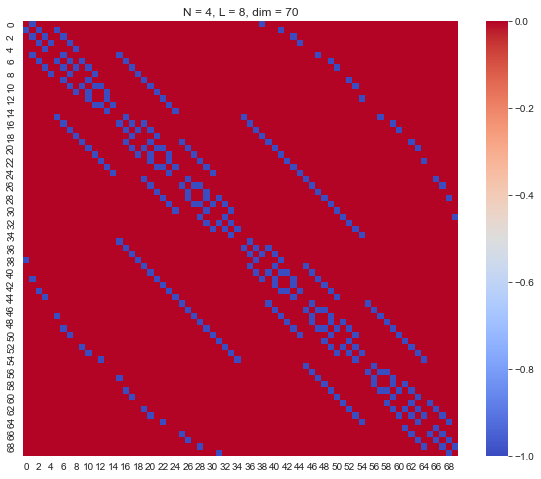

In [38]:
plt.figure(figsize=(10,8))
plt.title("N = {}, L = {}, dim = {}".format(N, M, D))
sns.heatmap(np.matrix((mat_int_dense+mat_dense)), square=True, cmap='coolwarm', annot=False)
# plt.savefig("BH Hamiltonian_N={}_L={}.pdf".format(N, M))

## All the processes are joined into this one function
(Minus the unnecesary conversions to dense matrices on the go)

In [28]:
# N - Number of particles in a system
N = 4
# M - Number of sites to fill
M = 8
# J - Hopping scaling factor
J = 1
# U - On-site potential scaling factor
U = 1
# Statistic (bose/fermi)
stat = 'b'
# Comp no
comp_no = 2
# Periodic bounary conditions
pbc = 0

# D - Dimension of the final Hamiltonian matrix
D = calc_Dim(M, N, statistic=stat)

/var/folders/4f/nc8733x97cnbfw1jfx_t9mfm0000gn/T/ipykernel_15153/1132752600.py:70: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ax.figure.show()


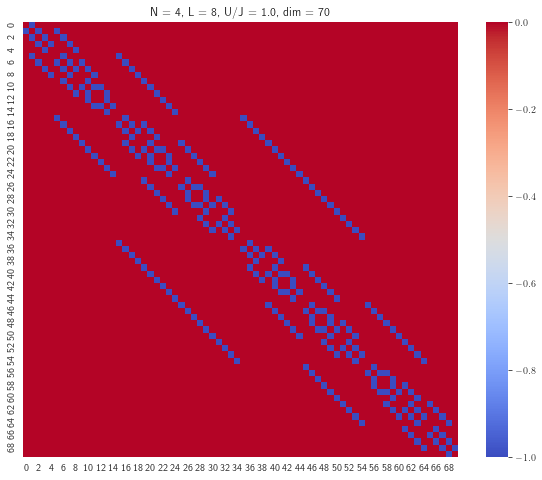

CPU times: user 994 ms, sys: 170 ms, total: 1.16 s
Wall time: 743 ms


In [135]:
%time H, Fock_Basis = get_Hamiltonian(N=N, M=M, J=J, U=U, pbc=pbc, statistic=stat, plot_accurate=True, annot_accurate=False, plot_sparsity_pattern=True, save_plot=True, return_basis=True, save_sparse=True, plot_show=True, n_components=1)

In [129]:
evals, evecs = sc.sparse.linalg.eigsh(H, 2, which='SA', return_eigenvectors=True)

In [130]:
evals

array([-5.74204451, -5.19584416])

In [131]:
delta_E = evals[1] - evals[0]
delta_E

0.5462003494572008

### Calculating the density matrix

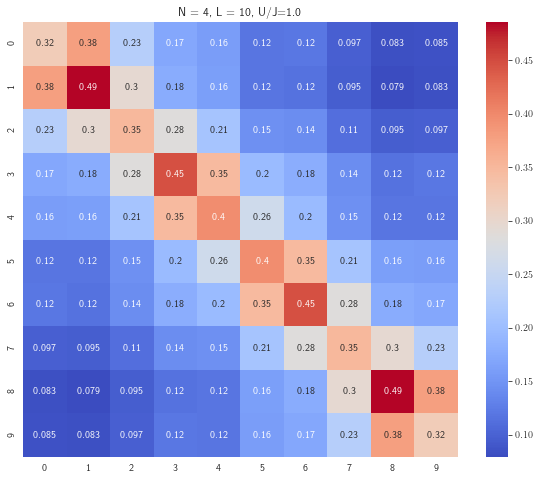

CPU times: user 1.34 s, sys: 124 ms, total: 1.47 s
Wall time: 1.24 s


In [132]:
%time rho_k = get_density_matrix(N, M, Fock_Basis, evecs, pbc, U, J, save_sparse=True, save_plot=True, plot_show=True, annot_plot=True)

Text(0.5, 0, '$i$')

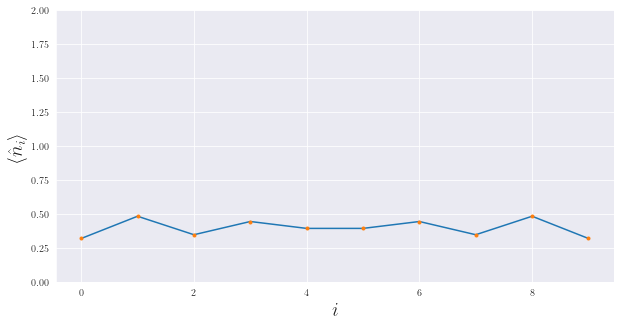

In [133]:
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(10,5))
plt.plot(np.arange(0,M), rho_k.diagonal())
plt.plot(np.arange(0,M), rho_k.diagonal(), lw=0, marker=".")
plt.ylim(0,2)
plt.ylabel(r'$\langle \hat{n}_i \rangle$', fontsize=20)
plt.xlabel(r'$i$', fontsize=20)

In [120]:
# %time plot_data = generate_data(N, M, J, np.arange(0,20, 1), plot_type='sparse')

In [121]:
# %%time
# U_tab = np.arange(0,20, 1)
# J = 1
# result_data = {}
# for (N,M) in notebook.tqdm([(9,9)]):
#     res = generate_data(N, M, J, U_tab, plot_type='off')
#     result_data["N={},M={}".format(N,M)] = res
#     with open("Result_pickles/results_N={},M={}".format(N,M), 'wb') as file_to_dump:
#         pickle.dump(res, file_to_dump)

In [122]:
result_data = {}
with open("Result_pickles/results_N=7,M=7", "rb") as file_read:
    result_data["N=7,M=7"] = pickle.load(file_read)

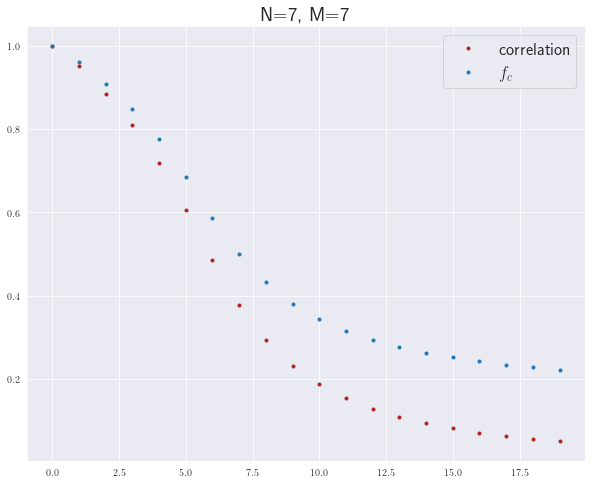

In [83]:
N_plot = 7
M_plot = N_plot
fig = plt.figure(figsize=(10,8))
plt.rcParams['text.usetex'] = True
plt.plot(result_data["N={},M={}".format(N_plot,M_plot)]["U/J"], result_data["N={},M={}".format(N_plot,M_plot)]["correlation"], marker=".", ls="", color="firebrick", label="correlation")
plt.plot(result_data["N={},M={}".format(N_plot,M_plot)]["U/J"], result_data["N={},M={}".format(N_plot,M_plot)]["f_c"], marker=".", ls="", label="$f_c$")
plt.title("N={}, M={}".format(N_plot,M_plot), fontsize="20")
plt.legend(fontsize='xx-large')

In [84]:
# for key in result_data.keys():
#     with open("Result_pickles/results_{}".format(key), 'wb') as file_to_dump:
#         pickle.dump(result_data[key], file_to_dump)

In [185]:
N_load = 7
M_load = N_load
hamiltonians = {}
hamiltonians["N={},M={}".format(N_load,M_load)] = load_sparse_coo("Hamiltonians/N={}_L={}/BH_Hamiltonian_N={}_L={}_U_J=10_00".format(N_load,M_load,N_load,M_load))

In [186]:
lambda_H, psi_ket = sc.sparse.linalg.eigsh(hamiltonians["N={},M={}".format(N_load,M_load)], 2, which='SA', return_eigenvectors=True)

In [187]:
psi_ket

array([[ 4.01300199e-12, -9.25935497e-11],
       [ 1.61375618e-10, -3.62108489e-09],
       [ 1.26955717e-09, -2.59994118e-08],
       ...,
       [ 2.50538551e-09, -5.44939250e-08],
       [ 1.61375512e-10, -3.62108492e-09],
       [ 4.01304018e-12, -9.25935830e-11]])

In [188]:
F_B = get_basis(M_load, N_load)

In [191]:
def show_wave_function(psket, Fock_Basis, high_num=3, plot_wf=False, label_ticks=False, print_all=False):
    res_dict = {}
    ket_to_sort = psket.copy()
    for alpha, basis_vec in zip(psket, Fock_Basis):
        res_dict[alpha] = basis_vec
    ket_to_sort[::-1].sort()
    highest_prob = ket_to_sort[0:high_num]
    for el in highest_prob:
        print("{:.4e}".format(el**2), res_dict[el])
    if print_all:
        for alpha, basis_vec in zip(psket, Fock_Basis):
            print("{:.4e}".format(alpha**2), basis_vec)
    if plot_wf:
        fig = plt.figure(figsize=(10,8))
        ax = plt.subplot(111)
        if label_ticks:
            ax.set_xticks(np.arange(0, Fock_Basis.shape[0], 1))
            ax.set_xticklabels(Fock_Basis,rotation=90)
        ax = plt.plot(np.arange(0, Fock_Basis.shape[0], 1), [(lambda alpha: alpha**2)(alpha) for alpha in psket])
        # ax.bar(np.arange(0, Fock_Basis.shape[0], 1), [(lambda alpha: alpha**2)(alpha) for alpha in psket])


        # ticker.StrMethodFormatter('{x}')
        # ax.axis.se

7.4674e-01 [1 1 1 1 1 1 1]
1.4779e-02 [1 1 1 1 1 0 2]
1.4779e-02 [1 1 2 0 1 1 1]


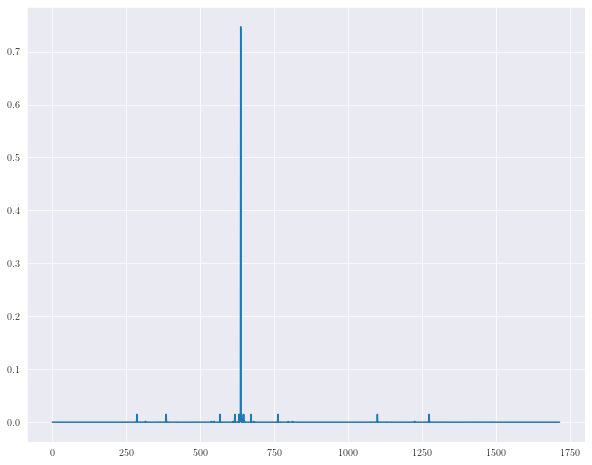

In [192]:
show_wave_function(psi_ket[:, 0], F_B, plot_wf=True, label_ticks=False)

In [197]:
calc_IPR(psi_ket[:, 0])

1.7834241229718721